In [61]:
knitr::opts_chunk$set(echo = FALSE)
library(magrittr)
library(dplyr) #Attaching dplyr library
library(tidyr) #Attaching tidyr library
#install.packages("lubridate")
library(lubridate) #R library to work with date times.
#install.packages("fastcluster")
library(fastcluster)
#install.packages("data.table")
library(data.table)
library(cluster)
library(ggplot2)
library(factoextra)
library(mclust)
'citation("mclust")'
library(class)

[1] "citation(\"mclust\")"

In [3]:
options(warn=-1)

### Data Cleaning

In [4]:
knitr::opts_chunk$set(warning = FALSE,message = FALSE)
folder="C:/Users/Pranathi/Desktop/MSBA/Fall/Exploratory data analytics/Assignment 2"
setwd(folder)
data<-fread("SunCountry.csv",stringsAsFactors=TRUE)
str(data)

Read 3435388 rows and 26 (of 26) columns from 0.712 GB file in 00:00:21
Classes 'data.table' and 'data.frame':	3435388 obs. of  26 variables:
 $ PNRLocatorID        : Factor w/ 1179997 levels "AAAACD","AAAAMU",..: 5 5 7 7 8 10 13 13 18 19 ...
 $ TicketNum           :Class 'integer64'  num [1:3435388] 1.67e-311 1.67e-311 1.67e-311 1.67e-311 1.67e-311 ...
 $ CouponSeqNbr        : int  2 1 2 1 1 1 1 1 1 1 ...
 $ ServiceStartCity    : Factor w/ 73 levels "ANC","AZA","BOS",..: 28 44 44 61 39 51 28 28 39 56 ...
 $ ServiceEndCity      : Factor w/ 80 levels "ABE","ANC","AUS",..: 52 35 70 52 52 52 52 52 52 52 ...
 $ PNRCreateDate       : Factor w/ 1146 levels "2011-06-22","2011-06-30",..: 742 742 815 815 852 329 1074 1074 935 787 ...
 $ ServiceStartDate    : Factor w/ 730 levels "2013-01-01","2013-01-02",..: 347 342 419 416 478 43 683 683 521 406 ...
 $ PaxName             : Factor w/ 506305 levels "A ALZI","AABEAL",..: 55635 55635 118333 118333 415852 189529 154602 154588 267745 418837 ...
 $ 

In [5]:
summary(data)

  PNRLocatorID       TicketNum  CouponSeqNbr   ServiceStartCity 
 OPKWDG :    558   Min.   :0   Min.   :1.000   MSP    :1612636  
 DILBDW :    484   1st Qu.:0   1st Qu.:1.000   LAS    : 176026  
 KOUWAC :    466   Median :0   Median :1.000   JFK    : 139477  
 OHYPCP :    458   Mean   :0   Mean   :1.464   MCO    : 135790  
 EJYFAM :    416   3rd Qu.:0   3rd Qu.:2.000   LAX    : 131661  
 MQYFIJ :    406   Max.   :0   Max.   :8.000   SFO    : 130449  
 (Other):3432600                               (Other):1109349  
 ServiceEndCity       PNRCreateDate       ServiceStartDate      PaxName       
 MSP    :1605351   2013-12-03:  15526   2014-11-30:   8919   JOHNMA :   2336  
 LAS    : 175819   2013-12-02:  14914   2014-03-16:   8885   JOHNJA :   1590  
 MCO    : 137147   2014-01-06:  11864   2014-02-16:   8855   JOHNBR :   1440  
 JFK    : 137084   2012-11-26:  11209   2014-01-05:   8824   ANDEMA :   1394  
 LAX    : 131552   2013-12-04:  11143   2014-12-28:   8814   JOHNJE :   1361  
 SFO  

In [6]:
#Filtering out records which have NA for BirthdateID
#same as data <- data %>%filter(!is.na(birthdateid)) 
data%<>%filter(!is.na(birthdateid)) 

data$GenderCode<-as.character(data$GenderCode)
data%<>%filter(GenderCode!="")

#Filtering out records which have ââ for GenderCode
data$GenderCode<-as.factor(data$GenderCode)

#Replacing negative ages with median value
data$Age[data$Age < 0] <- median(data$Age)

#Replacing age values greater than 120 with median value
data$Age[data$Age > 120] <- median(data$Age)

#Replace NAs with 0
data$UFlyRewardsNumber[is.na(data$UFlyRewardsNumber)] <- 0

#Convert factor level data to string
data$UflyMemberStatus<-as.character(data$UflyMemberStatus)

#Replace missing values with ânon-uflyâ 
data$UflyMemberStatus[data$UflyMemberStatus==''] <-"non-ufly"


#Retaining only those rows which have single occurrence of PNRLocatorID, CouponSeqNbr, PaxName, 
#ServiceStartCity, ServiceEndCity, ServiceStartDate combination.
data%<>%
  group_by(PNRLocatorID,CouponSeqNbr,PaxName,ServiceStartCity,ServiceEndCity,ServiceStartDate)%>%
  filter(n()==1)


#Remove rows with faulty city codes as BookingChannel. Some rows have city names for Booking Channel.
data$BookingChannel<-as.character(data$BookingChannel)
data$BookingChannel[data$BookingChannel!="Outside Booking" & 
                      data$BookingChannel!="SCA Website Booking" & 
                      data$BookingChannel!="Tour Operator Portal" & 
                      data$BookingChannel!="Reservations Booking" & 
                      data$BookingChannel!="SY Vacation"] <- "Other"
data$BookingChannel<-as.factor(data$BookingChannel)

#Remove rows with MarketingAirlineCode code other than âSYâ, the airline code for Sun Country.
data$MarketingAirlineCode<-as.character(data$MarketingAirlineCode)
data%<>%filter(MarketingAirlineCode=="SY")
data$MarketingAirlineCode<-as.factor(data$MarketingAirlineCode)

#Creating a new column called error which contains 1 if the PNR is errored or 0 otehrwise.
#Error PNR refers to those which do not start with coupon sequence number 1.
data%<>%group_by(PNRLocatorID)%>%
  mutate(error= ifelse(min(CouponSeqNbr)!=1,1,0))

#Retaining only the non errored rows and check how many rows are remaining.
data%<>%filter(error==0)
nrow(data)

[1] 3073826

### Data Sampling
Since the data, after transformation, has 3.2 million rows, we take a sample of the data to perform further analysis to facilitate R to handle the data with ease. Since the data is at the level of one row per flight, just taking a random sample of the rows will distort the trip details. So, we take a sample of the PNRLocatorIDs and retain all the records belonging to the sampled PNRs.

In [7]:
#Obtain Unique PNRs
uniquePNRs<-unique(data$PNRLocatorID) 

#To produce the same samples every time the code is run
set.seed(1234567)


sample_PNRs<-sample(uniquePNRs,10000)

#Obtaining data related to the sampled 10,000 PNRs
sample_data<-data%>%filter(PNRLocatorID %in% sample_PNRs)

### Data Transformation

In [8]:
#First, create a Unique ID for each customer by concatenating Encrypted name, GenderCode and birthdateid.
sample_data<-sample_data%>% mutate(uid=paste(EncryptedName,GenderCode,birthdateid,sep=""))

#Next, we bin the customers' age into 1 of 5 age buckets
sample_data%<>%mutate(age_group = 
                        ifelse(Age>=0 & Age<18,"0-17",
                               ifelse(Age>=18 & Age < 25,"18-24",
                                      ifelse(Age>=25&Age<35,"25-34",
                                             ifelse(Age>=35 & Age<55,"35-54",
                                                    ifelse(Age>=55,"55+",0)
                                                    )
                                             )
                                      )
                               )
                    )

#Next, we determining the true Service Start City for each row in the data. It will be the First city from which 
#the trip started 
true_origins<-sample_data%>%
  arrange(PNRLocatorID,CouponSeqNbr)%>%
  group_by(PNRLocatorID,PaxName)%>%
  do(data.frame(true_origin = first(.$ServiceStartCity)))

sample_data<-merge(sample_data,true_origins,
                   by.x=c("PNRLocatorID","PaxName"),
                   by.y = c("PNRLocatorID","PaxName"))

#Next, we determine where the trip ended. If the trip is a round trip, the service end city (Final Destination) 
#will be the same as the service start city (True Origin)
final_destination<-sample_data%>%
  arrange(PNRLocatorID,CouponSeqNbr)%>%
  group_by(PNRLocatorID,PaxName)%>% 
  do(data.frame(final_destination = last(.$ServiceEndCity)))
  

sample_data<-merge(sample_data,final_destination,
                   by.x=c("PNRLocatorID","PaxName"),
                   by.y = c("PNRLocatorID","PaxName"))


#Next, we determine what was the trips true destination. We assume this was the place where most time was spent on the trip.
#Convert Service Start date to Date type
sample_data$ServiceStartDate<-as.Date(sample_data$ServiceStartDate)

#The place of maximum stay during the trip.
diff1<-sample_data%>%
  arrange(PNRLocatorID,CouponSeqNbr)%>%
  group_by(PNRLocatorID,PaxName)%>%
  mutate(stay=lead(ServiceStartDate)-ServiceStartDate,default=0)%>%
  select(PNRLocatorID,PaxName,ServiceStartCity,ServiceEndCity,ServiceStartDate,stay)

diff1$stay[is.na(diff1$stay)]<-0
diff1$stay<-as.numeric(diff1$stay)

true_destination<-diff1%>%
  group_by(PNRLocatorID,PaxName)%>%
  do(data.frame(true_destination= first(as.character(.$ServiceEndCity)[.$stay==max(.$stay)])))

sample_data<-merge(sample_data,true_destination,
                   by.x=c("PNRLocatorID","PaxName"),
                   by.y = c("PNRLocatorID","PaxName"))

#Next, we determine if the trip was a one-way or round-trip. The trip is considered a round trip if the service end city 
#(Final Destination) will be the same as the service start city (True Origin).
sample_data%<>%
  mutate(round_trip = ifelse(as.character(true_origin)==as.character(final_destination), 1, 0))

#Next, we determine the group size, the number of people who traveled together in each trip.
sample_data%<>%
  group_by(PNRLocatorID)%>%
  mutate(group_size= length(unique(uid)))

#Next, we have a special inidcator if the group-size was 1,i.e., flown by a single customer
sample_data%<>%
  group_by(PNRLocatorID)%>%
  mutate(group= ifelse(group_size>1,1,0))

#Next, handle seasonality in terms of quaters. Assign Q1 to Q4 based on the quarter of the year in which the trip was made

sample_data$ServiceStartDate<-as.Date(sample_data$ServiceStartDate)
#Convert ServiceStartDate from factor to Date format
sample_data%<>%
  group_by(PNRLocatorID,PaxName)%>%
  mutate(seasonality= ifelse(month(ServiceStartDate)>=1 & month(ServiceStartDate)<=3,"Q1",
                             ifelse(month(ServiceStartDate)>=4 & month(ServiceStartDate)<=6,"Q2",
                                    ifelse(month(ServiceStartDate)>=7 & month(ServiceStartDate)<=9,"Q3",
                                           ifelse(month(ServiceStartDate)>=10 & month(ServiceStartDate)<=12,"Q4",0)
                                           )
                                    )
                             )
         )

#Finally, we calculate the number of days the ticket was booked in advance. It is the difference between 
#PNRCreateDate and ServiceStartDate

sample_data$PNRCreateDate <- as.Date(sample_data$PNRCreateDate) 
sample_data$ServiceStartDate <- as.Date(sample_data$ServiceStartDate)
sample_data%<>% 
  mutate(days_pre_booked=as.numeric(floor( difftime(ServiceStartDate,
                                                    PNRCreateDate,units=c("days")))))

In [9]:

#memory.limit(size=15000)
memory.size(max=NA)
memory.limit(size=20000)

[1] 7890.28

[1] 20000

## Customer Segmentation
We want to use the data to segment customers of Sun Country Airlines into general categories of people with similar 
flying patterns. The goal is to group the observations in the data into clusters such that every datum in a cluster is
more similar to other datums in the same cluster than it is to datums in other clusters.

### Change data granularity
In order to run the segmentation algorithm, we need to first have the data at the right granularity. Since we are
looking to segment customers, it is important to bring the data to the granularity of customers. We transform the data
such that each row represents a unique customer-PNR combination.


In [10]:
sample_data%<>%
  select(PNRLocatorID, uid, PaxName, ServiceStartDate, BookingChannel, TotalDocAmt,
         UFlyRewardsNumber,UflyMemberStatus, age_group,true_origin,true_destination,
         round_trip,group_size,group, seasonality,days_pre_booked)

#This may take a considerable amount of time
customer_data<-sample_data%>%
  group_by(PNRLocatorID,uid)%>%
  summarise( ServiceStartDate=first(ServiceStartDate),
            BookingChannel=first(BookingChannel), 
            avg_amt=max(TotalDocAmt),
            UFlyRewards=first(UFlyRewardsNumber),
            UflyMemberStatus=first(UflyMemberStatus),
            age_group=last(age_group),
            true_origin=first(true_origin),
            true_destination=first(true_destination),
            round_trip=first(round_trip),
            group_size=first(group_size),
            group=first(group), 
            seasonality=last(seasonality), 
            days_pre_booked=max(days_pre_booked))

#Retaining only those attributes that are meaningful for clustering
customer_data%<>%
  select(-PNRLocatorID,-uid,-ServiceStartDate,-UFlyRewards)
  nrow(sample_data)

Adding missing grouping variables: `PNRLocatorID`


[1] 26325

In [11]:
#Granularity of data was reduced to customer level
nrow(customer_data)
str(customer_data)

[1] 15181

Classes 'grouped_df', 'tbl_df', 'tbl' and 'data.frame':	15181 obs. of  12 variables:
 $ PNRLocatorID    : Factor w/ 1179997 levels "AAAACD","AAAAMU",..: 337 340 340 340 340 356 447 462 468 468 ...
 $ BookingChannel  : Factor w/ 6 levels "Other","Outside Booking",..: 4 2 2 2 2 2 2 2 4 4 ...
 $ avg_amt         : num  408 1301 1301 1301 1301 ...
 $ UflyMemberStatus: chr  "Standard" "non-ufly" "non-ufly" "non-ufly" ...
 $ age_group       : chr  "0-17" "35-54" "0-17" "35-54" ...
 $ true_origin     : Factor w/ 73 levels "ANC","AZA","BOS",..: 44 44 44 44 44 61 8 3 28 28 ...
 $ true_destination: chr  "JFK" "LIR" "LIR" "LIR" ...
 $ round_trip      : num  1 1 1 1 1 0 1 0 1 1 ...
 $ group_size      : int  1 4 4 4 4 1 1 1 2 2 ...
 $ group           : num  0 1 1 1 1 0 0 0 1 1 ...
 $ seasonality     : chr  "Q3" "Q1" "Q1" "Q1" ...
 $ days_pre_booked : num  60 80 80 80 80 69 25 1 9 9 ...
 - attr(*, "vars")=List of 1
  ..$ : symbol PNRLocatorID
 - attr(*, "drop")= logi TRUE
 - attr(*, "indices")=List o

### Units and Scaling
The initial understanding of the data has shown us that this contains attributes of different units. Units affect what
clustering algorithms will discover. One way to try to make the clustering more coordinate- free is to transform all 
the columns to have a value between 0 and 1. This is called Normalization. There are multiple techniques of achieving 
normalization. We will be using the min-max normalization technique.

In [12]:
#Min-Max normalization: x= x-max/max-min
normalize <- function(x){return ((x - min(x))/(max(x) - min(x)))}

customer_data <- ungroup(customer_data)

customer_data_km = mutate(customer_data,
                     avg_amt = normalize(avg_amt),
                     days_pre_booked = normalize(days_pre_booked),
                     group_size=normalize(group_size))

In [13]:
customer_data_km_1<-select(customer_data_km,-PNRLocatorID, -true_origin, -true_destination)
str(customer_data_km_1)

Classes 'tbl_df', 'tbl' and 'data.frame':	15181 obs. of  9 variables:
 $ BookingChannel  : Factor w/ 6 levels "Other","Outside Booking",..: 4 2 2 2 2 2 2 2 4 4 ...
 $ avg_amt         : num  0.236 0.753 0.753 0.753 0.753 ...
 $ UflyMemberStatus: chr  "Standard" "non-ufly" "non-ufly" "non-ufly" ...
 $ age_group       : chr  "0-17" "35-54" "0-17" "35-54" ...
 $ round_trip      : num  1 1 1 1 1 0 1 0 1 1 ...
 $ group_size      : num  0 0.375 0.375 0.375 0.375 0 0 0 0.125 0.125 ...
 $ group           : num  0 1 1 1 1 0 0 0 1 1 ...
 $ seasonality     : chr  "Q3" "Q1" "Q1" "Q1" ...
 $ days_pre_booked : num  0.114 0.152 0.152 0.152 0.152 ...


### Mixed Distance Calculation

In [14]:
#Gover distance calculation

#install.packages()
cols <- c("UflyMemberStatus","age_group","seasonality")
customer_data_km_1[cols] <- lapply(customer_data_km_1[cols], as.factor)


distance_gower <- daisy(customer_data_km_1,metric ="gower", stand = FALSE)


In [15]:
str(customer_data_km_1)

Classes 'tbl_df', 'tbl' and 'data.frame':	15181 obs. of  9 variables:
 $ BookingChannel  : Factor w/ 6 levels "Other","Outside Booking",..: 4 2 2 2 2 2 2 2 4 4 ...
 $ avg_amt         : num  0.236 0.753 0.753 0.753 0.753 ...
 $ UflyMemberStatus: Factor w/ 3 levels "Elite","non-ufly",..: 3 2 2 2 2 2 2 1 2 2 ...
 $ age_group       : Factor w/ 5 levels "0-17","18-24",..: 1 4 1 4 1 2 2 4 3 3 ...
 $ round_trip      : num  1 1 1 1 1 0 1 0 1 1 ...
 $ group_size      : num  0 0.375 0.375 0.375 0.375 0 0 0 0.125 0.125 ...
 $ group           : num  0 1 1 1 1 0 0 0 1 1 ...
 $ seasonality     : Factor w/ 4 levels "Q1","Q2","Q3",..: 3 1 1 1 1 3 4 4 4 4 ...
 $ days_pre_booked : num  0.114 0.152 0.152 0.152 0.152 ...


### K-Means Clustering

In [16]:
customer_data_km_2<-select(customer_data_km_1,-BookingChannel, -UflyMemberStatus,-age_group, -round_trip, -group, -seasonality)
#Numerical variables distance matrix

dist_km = dist(customer_data_km_2, method = "euclidean")


In [17]:
summary(dist_km)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1521  0.2420  0.2695  0.3687  1.3610 

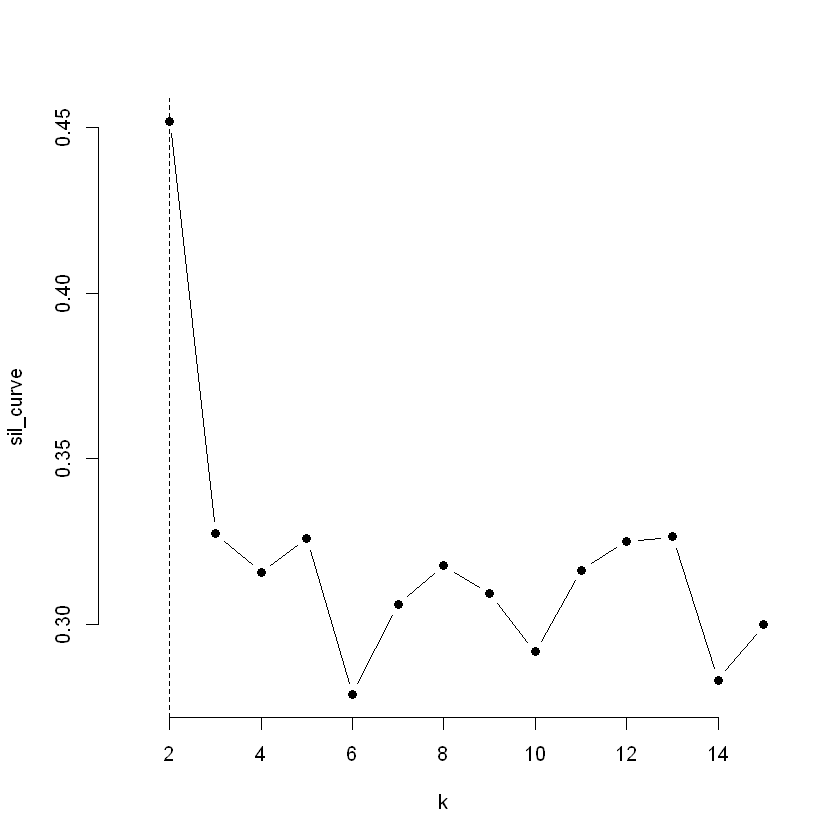

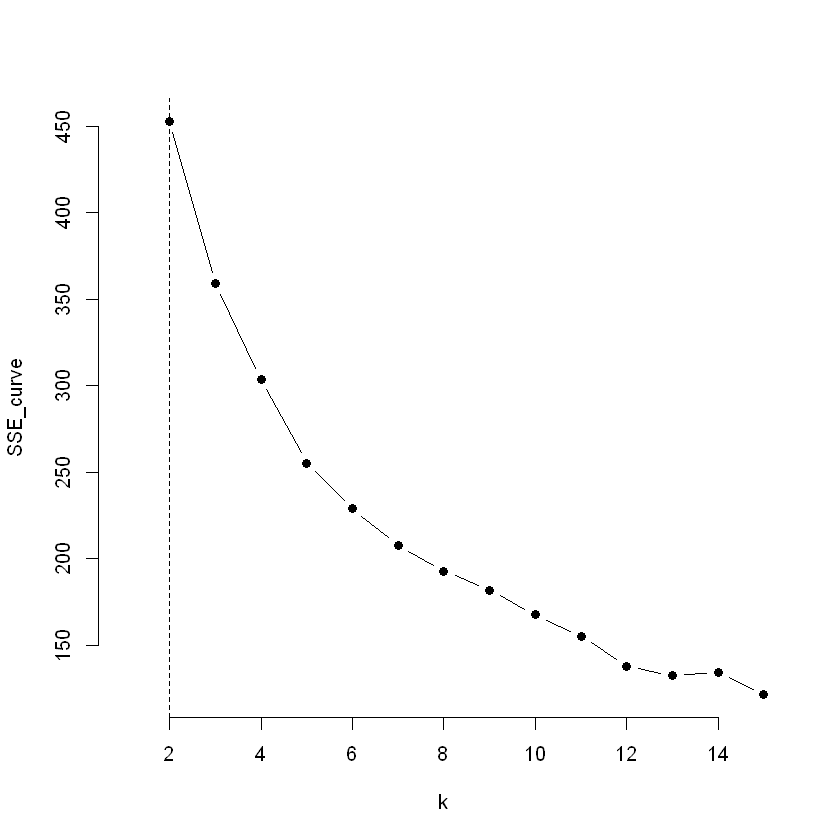

In [18]:
#SSE
SSE_curve <- c()
sil_curve <- c()

for (n in 2:15) {
  kcluster <- kmeans(customer_data_km_2, n)
  sse <- sum(kcluster$withinss)
  sil <- mean(silhouette(kcluster$cluster,dist_km)[, 3])
  SSE_curve[n] <- sse
  sil_curve[n] <- sil           
}

plot(1:15, sil_curve, type = "b", pch = 19, frame = FALSE, xlab = "k")
abline(v = which.max(sil_curve), lty = 2)

plot(1:15, SSE_curve, type = "b", pch = 19, frame = FALSE, xlab = "k")
abline(v = which.max(SSE_curve), lty = 2)




From silhoutee coeffcient plot, K = 5 has good cluster quality compared to other K's

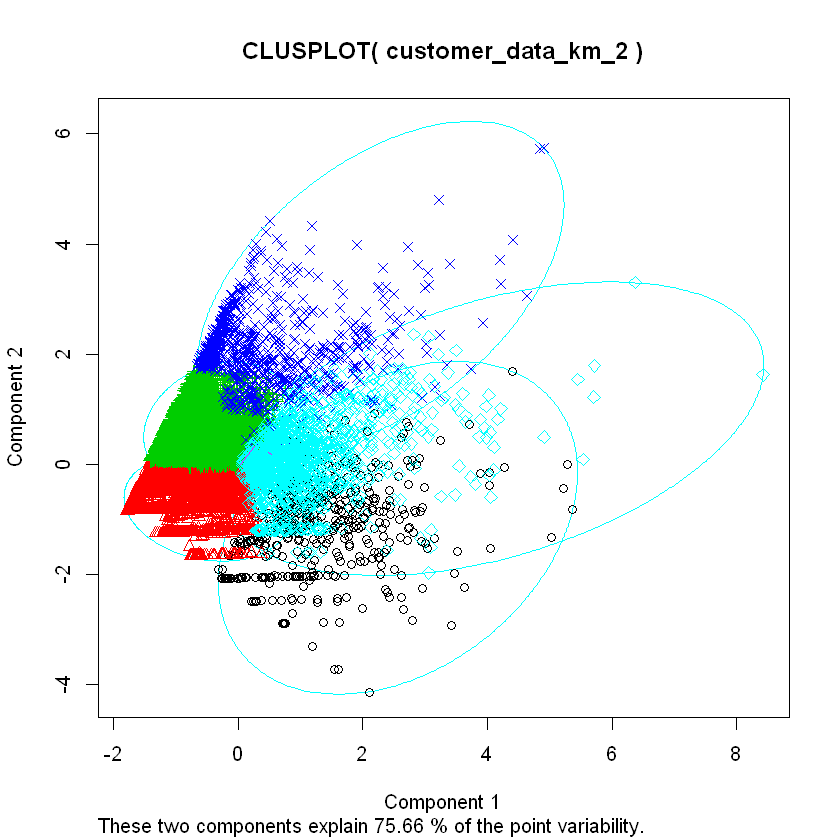

In [25]:
#Visualization of clusters

clusters <- kmeans(customer_data_km_2,5)
clusplot(customer_data_km_2, clusters$cluster, cex=1, col.p=clusters$cluster)



### K-Mediods

In [20]:
sil_coeff_med <- c()

for(n in 2:8)
{part_med <- pam(distance_gower,
                 diss = TRUE,
                 k = n)
 sil_coeff_med[n] <- part_med$silinfo$avg.width
}

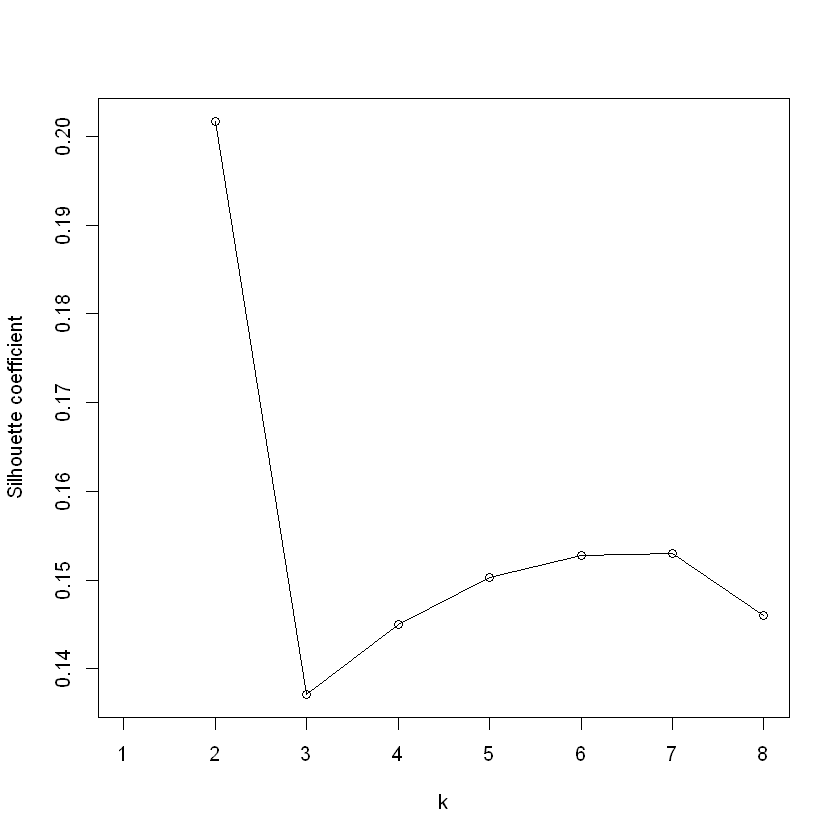

In [21]:
plot(1:8, sil_coeff_med,
     xlab = "k",
     ylab = "Silhouette coefficient")
lines(1:8, sil_coeff_med)

For K-mediods, K = 7 has good cluster quality but not better than K-means

### Hierarchial Clustering

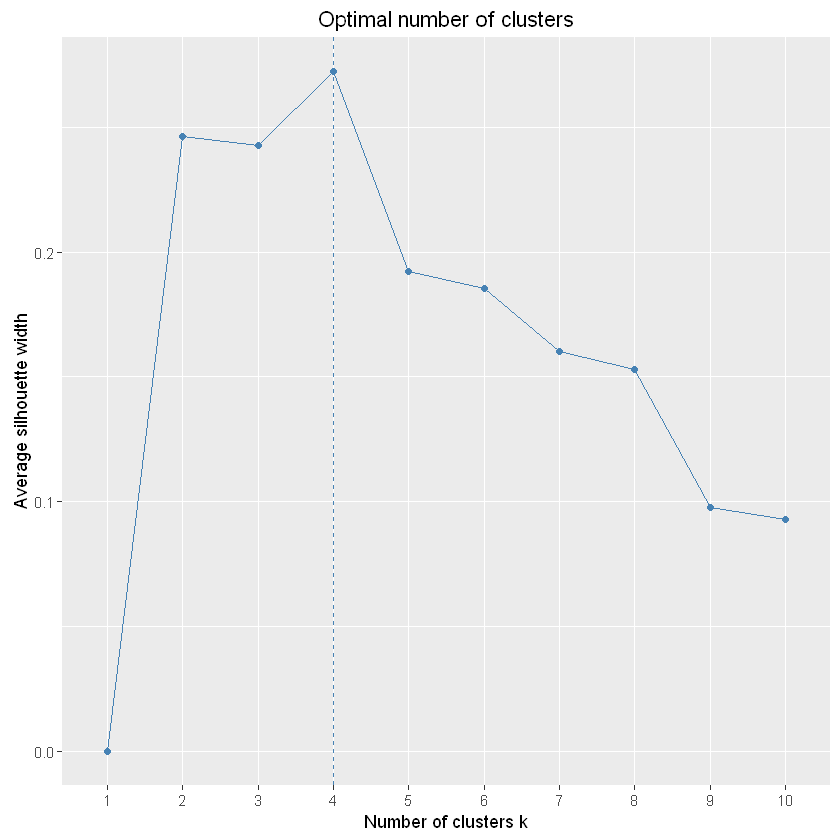

In [22]:
#Hierarchial clustering - mixed variables
fviz_nbclust(customer_data_km_1,hcut,diss = distance_gower, method = "silhouette",hc_method = "ward.D2") 

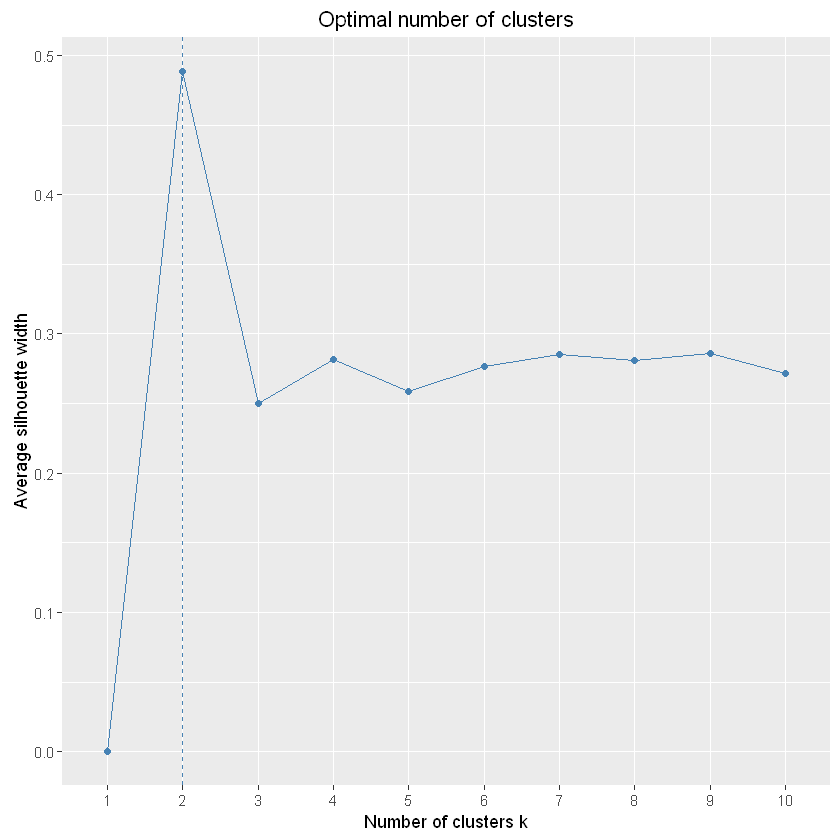

In [23]:
fviz_nbclust(customer_data_km_2,hcut,diss = dist_km, method = "silhouette",hc_method = "ward.D2")

Out of all the methods, K-means gives the best clusters

### K-Means Cluster Analysis

In [42]:
k_means <- customer_data
k_means$cluster <- clusters$cluster
k_means$cluster <- as.factor(k_means$cluster)

In [43]:
#Final best solution
summary(k_means)
str(k_means)

  PNRLocatorID                BookingChannel    avg_amt      
 JVTPTI :    9   Other               :  60   Min.   :   0.0  
 QYTONT :    9   Outside Booking     :6697   1st Qu.: 163.9  
 FFNXHO :    8   Reservations Booking: 591   Median : 277.8  
 HVKYVF :    8   SCA Website Booking :7038   Mean   : 293.5  
 JTVXVW :    8   SY Vacation         : 296   3rd Qu.: 388.8  
 AJRVGF :    7   Tour Operator Portal: 499   Max.   :1727.2  
 (Other):15132                                               
 UflyMemberStatus    age_group          true_origin   true_destination  
 Length:15181       Length:15181       MSP    :9387   Length:15181      
 Class :character   Class :character   DFW    : 695   Class :character  
 Mode  :character   Mode  :character   JFK    : 683   Mode  :character  
                                       LAX    : 600                     
                                       SFO    : 556                     
                                       BOS    : 496               

Classes 'tbl_df', 'tbl' and 'data.frame':	15181 obs. of  13 variables:
 $ PNRLocatorID    : Factor w/ 1179997 levels "AAAACD","AAAAMU",..: 337 340 340 340 340 356 447 462 468 468 ...
 $ BookingChannel  : Factor w/ 6 levels "Other","Outside Booking",..: 4 2 2 2 2 2 2 2 4 4 ...
 $ avg_amt         : num  408 1301 1301 1301 1301 ...
 $ UflyMemberStatus: chr  "Standard" "non-ufly" "non-ufly" "non-ufly" ...
 $ age_group       : chr  "0-17" "35-54" "0-17" "35-54" ...
 $ true_origin     : Factor w/ 73 levels "ANC","AZA","BOS",..: 44 44 44 44 44 61 8 3 28 28 ...
 $ true_destination: chr  "JFK" "LIR" "LIR" "LIR" ...
 $ round_trip      : num  1 1 1 1 1 0 1 0 1 1 ...
 $ group_size      : int  1 4 4 4 4 1 1 1 2 2 ...
 $ group           : num  0 1 1 1 1 0 0 0 1 1 ...
 $ seasonality     : chr  "Q3" "Q1" "Q1" "Q1" ...
 $ days_pre_booked : num  60 80 80 80 80 69 25 1 9 9 ...
 $ cluster         : Factor w/ 5 levels "1","2","3","4",..: 3 4 4 4 4 2 2 3 3 3 ...


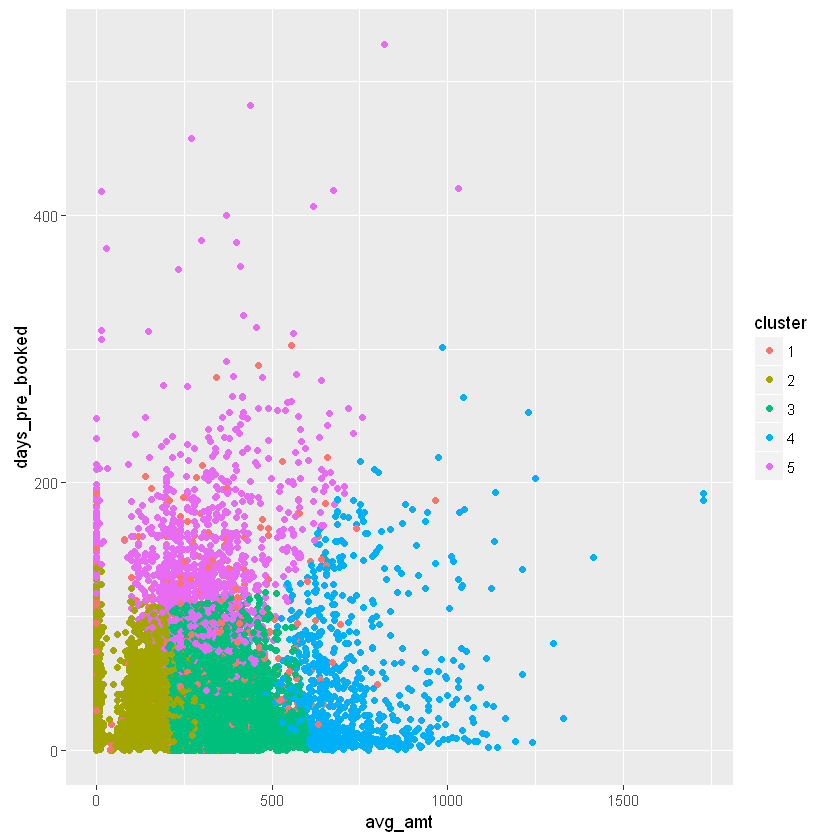

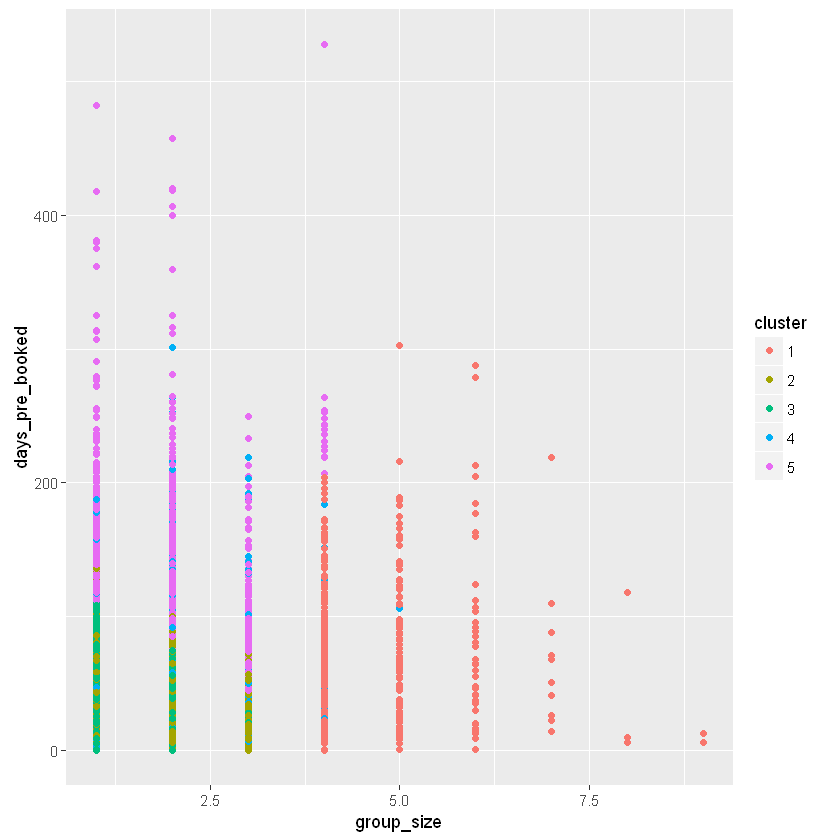

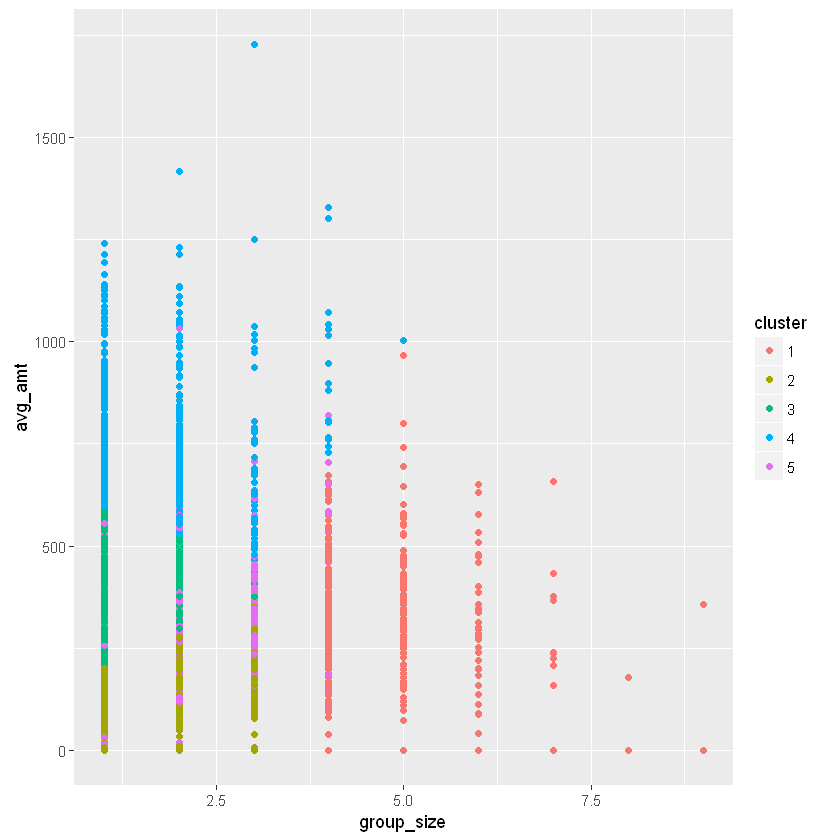

In [56]:
# Visualizing the clusters

ggplot(k_means) + geom_point(aes(x=avg_amt,y=days_pre_booked, color = cluster))
ggplot(k_means) + geom_point(aes(x=group_size,y=days_pre_booked, color = cluster))
ggplot(k_means) + geom_point(aes(x=group_size,y=avg_amt, color = cluster))


Cluster 1 is mostly distinguished by group_size. For avg amount and pre booking days, cluster 1 is all over the place

In [141]:
cluster_center<-k_means%>%
  group_by(cluster)%>%
  summarise(avg_amt=mean(avg_amt),
            days_pre_booked=mean(days_pre_booked),
            group_size=mean(group_size),
            count=n()
            )
cluster_center

cluster,avg_amt,days_pre_booked,group_size,count
1,265.5011,70.18724,4.660723,2131
2,127.4618,34.02206,1.647009,4714
3,354.7694,35.80460,1.283867,4872
4,730.1190,56.44884,1.859736,1212
5,300.3376,130.88988,2.152753,2252


## Cluster Names

1- Advance booking Group Travellers
2- Low spending single Travellers
3- Medium spending single travellers
4- High Spending medium advance booking travellers
5- Advance booking Couple travellers


BookingChannel,cluster,percentage
Other,2,60.000000
Other,3,28.333333
Other,4,10.000000
Other,5,1.666667
Outside Booking,1,13.379125
Outside Booking,2,31.581305
Outside Booking,3,34.761834
Outside Booking,4,7.451098
Outside Booking,5,12.826639
Reservations Booking,1,6.260575


BookingChannel,count
Other,60
Outside Booking,6697
Reservations Booking,591
SCA Website Booking,7038
SY Vacation,296
Tour Operator Portal,499


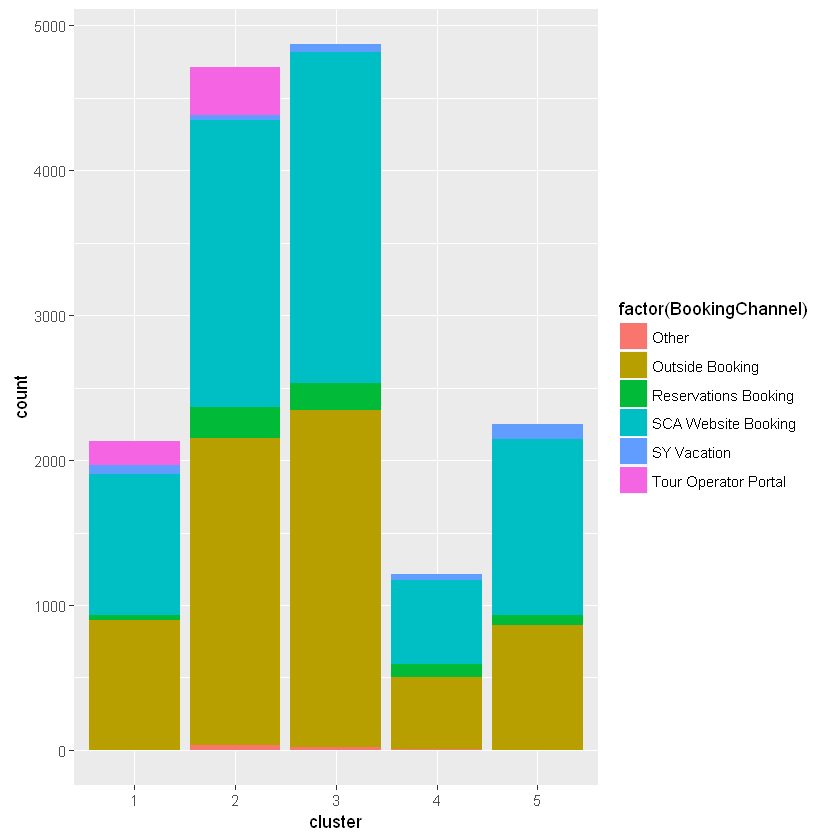

In [150]:
ggplot(k_means) + geom_bar(aes(cluster, fill = factor(BookingChannel))) 

booking_channel<-k_means%>%
  group_by(BookingChannel)%>%
  mutate(count=n())%>%
  group_by(BookingChannel,cluster)%>%
  mutate(percentage=(n()/count)*100)%>%
  arrange(BookingChannel,cluster)%>%
  summarise(percentage = max(percentage))

booking_channel

booking_count<-k_means%>%
  group_by(BookingChannel)%>%
  summarise(count=n())

booking_count


1. Out of all the people who use SY vacation, Advance booking couple travellers use it the most and single travellers use it the least
2. Around 50% of the single travellers use website booking

age_group,cluster,percentage
0-17,1,43.663664
0-17,2,19.639640
0-17,3,13.513514
0-17,4,6.546547
0-17,5,16.636637
18-24,1,11.384820
18-24,2,38.282290
18-24,3,35.685752
18-24,4,5.858855
18-24,5,8.788282


age_group,count
0-17,1665
18-24,1502
25-34,3010
35-54,4966
55+,4038


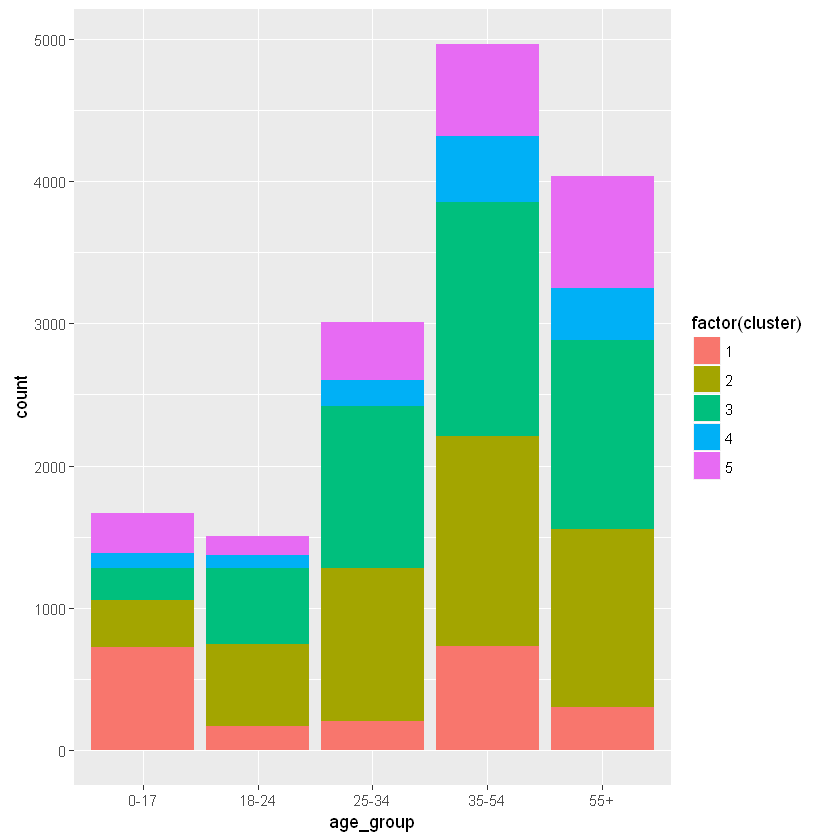

In [154]:
ggplot(k_means) + geom_bar(aes(age_group, fill = factor(cluster)))

age<-k_means%>%
  group_by(age_group)%>%
  mutate(count=n())%>%
  group_by(age_group,cluster)%>%
  mutate(percentage=(n()/count)*100)%>%
  arrange(cluster,age_group)%>%
  summarise(percentage = max(percentage))

age

age_count<-k_means%>%
  group_by(age_group)%>%
  summarise(count=n())

age_count

1. Out of all the people aged 0-17, advance booking group travellers are around 50%
2. More than 75% of the people aged 18-24 are single travellers
3. Advance booking couple travellers has the lowest presence in people aged 18-24
4. Advance booking group travllers has highest presence in people aged 0-17 & 35-54
5. Low spending single travellers has the least presence in 0-17

UflyMemberStatus,cluster,percentage
Elite,1,3.174603
Elite,2,28.571429
Elite,3,50.793651
Elite,4,15.873016
Elite,5,1.587302
non-ufly,1,14.928149
non-ufly,2,32.459848
non-ufly,3,31.986475
non-ufly,4,7.075232
non-ufly,5,13.550296


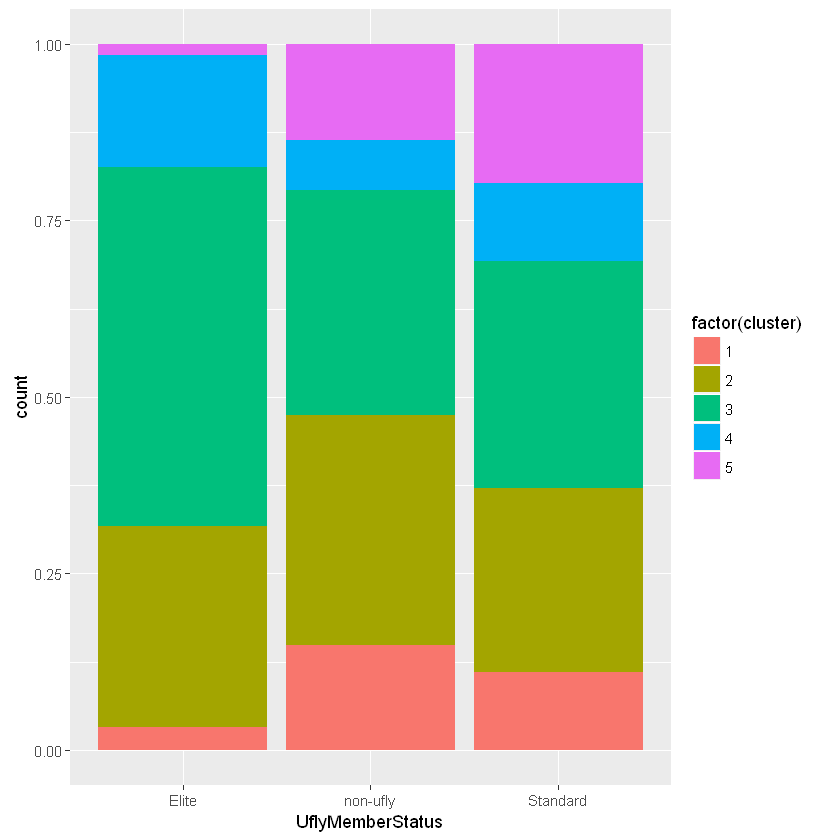

In [157]:
ggplot(k_means) + geom_bar(aes(UflyMemberStatus, fill = factor(cluster)),position = "fill")

ufly<-k_means%>%
  group_by(UflyMemberStatus)%>%
  mutate(count=n())%>%
  group_by(UflyMemberStatus,cluster)%>%
  mutate(percentage=(n()/count)*100)%>%
  summarise(percentage=max(percentage))%>%
  arrange(UflyMemberStatus,cluster)

ufly

1. Less than 10% of elite travellers are Advance booking group travellers and Advance booking couple travellers
2. Most of the elite group is medium spending single travellers
3. High spending medium adv booking travellers has the least presence in non-ufly

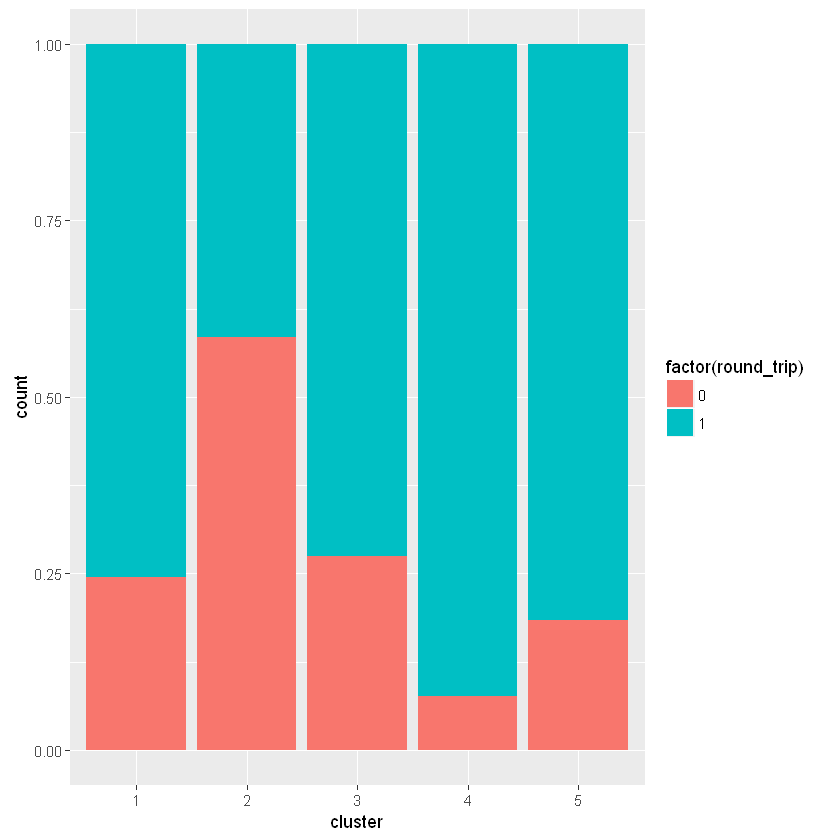

In [104]:
ggplot(k_means) + geom_bar(aes(cluster, fill = factor(round_trip)),position = "fill")

1. High spending medium advance booking travellers don't book for round trips
2. Low spending single travellers book round trips mostly

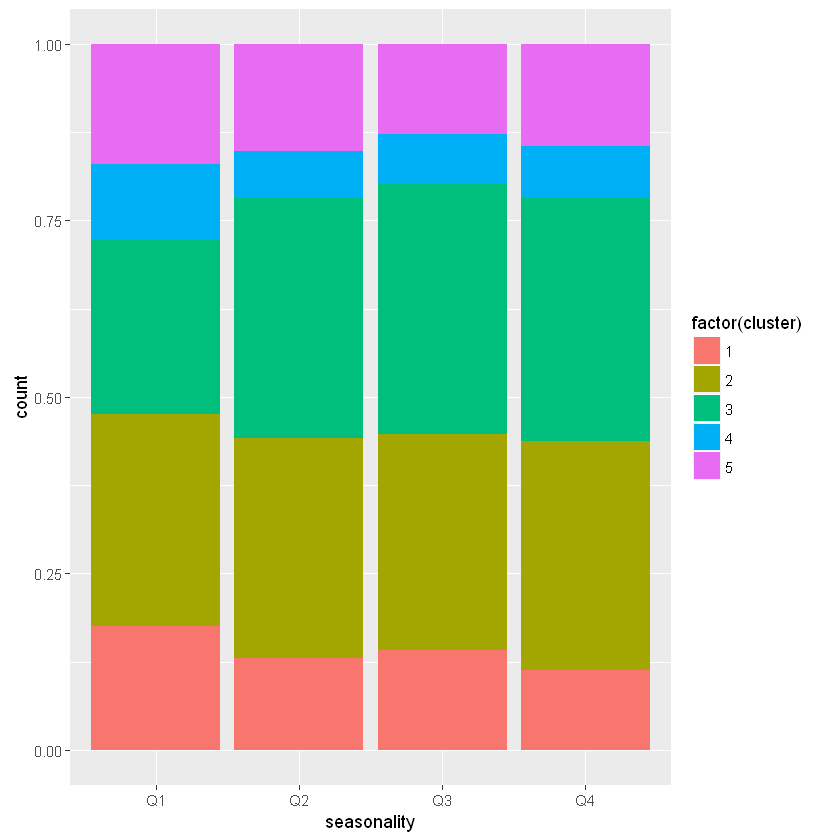

In [158]:
ggplot(k_means) + geom_bar(aes(seasonality, fill = factor(cluster)),position = "fill")

### Raw Data Analysis

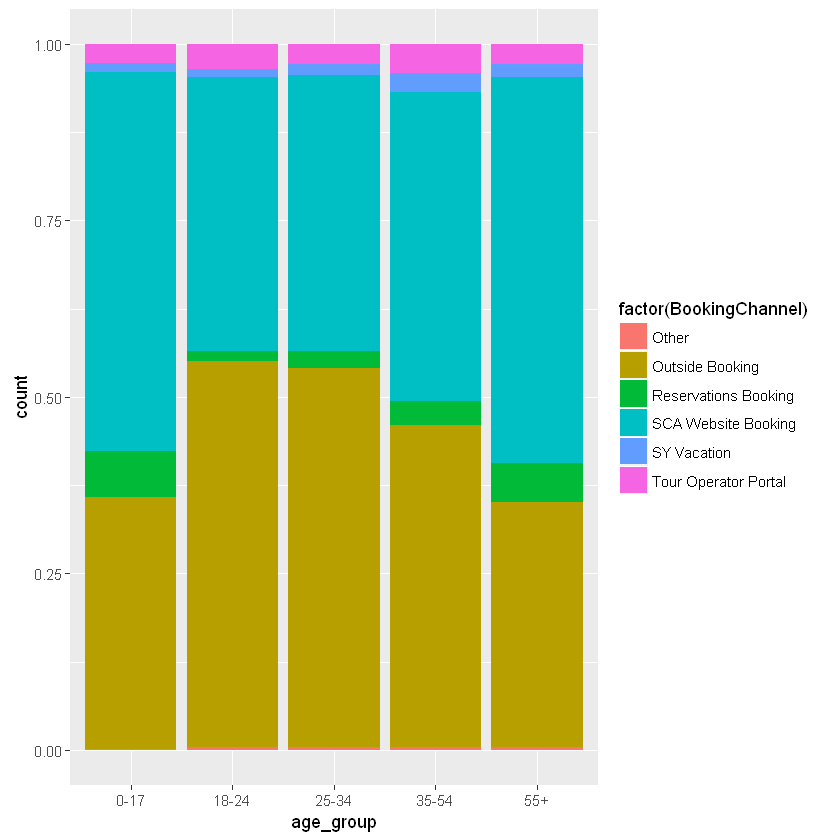

In [164]:
#age and booking channel
ggplot(k_means) + geom_bar(aes(age_group, fill = factor(BookingChannel)),position = "fill")

1. Outside booking has its highest presence in age group 18-34
2. Website booking has its highest presence in 0-17 and 5+

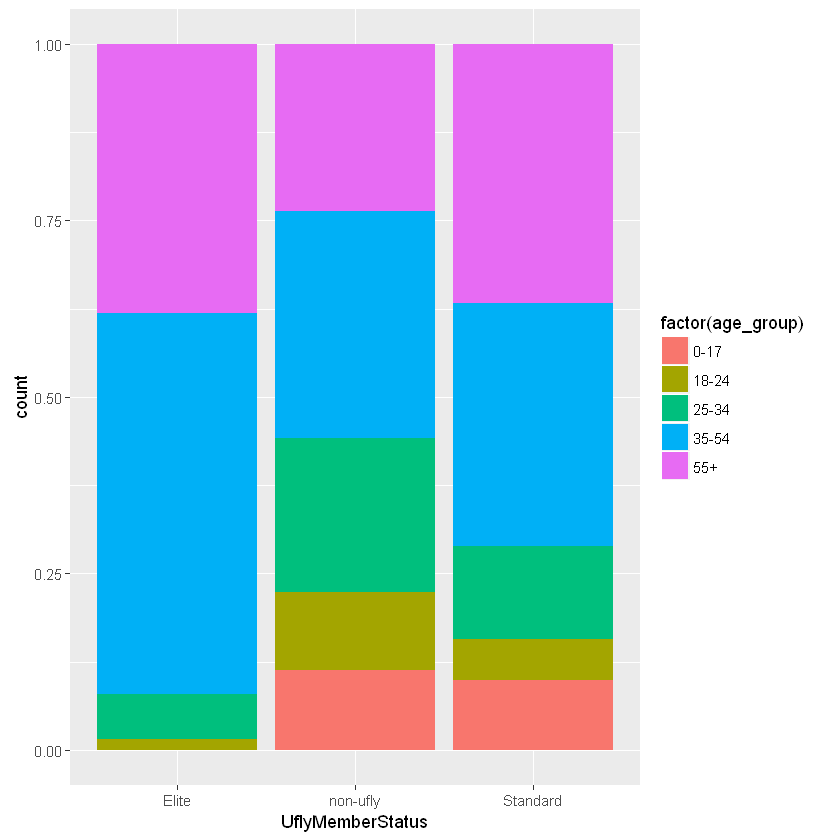

In [167]:
### Age and ufly memeber ship
ggplot(k_means) + geom_bar(aes(UflyMemberStatus, fill = factor(age_group)),position = "fill")

 0-17 doesn't have elite membership
Most of the 18-24 age group doesn't have ufly member ship

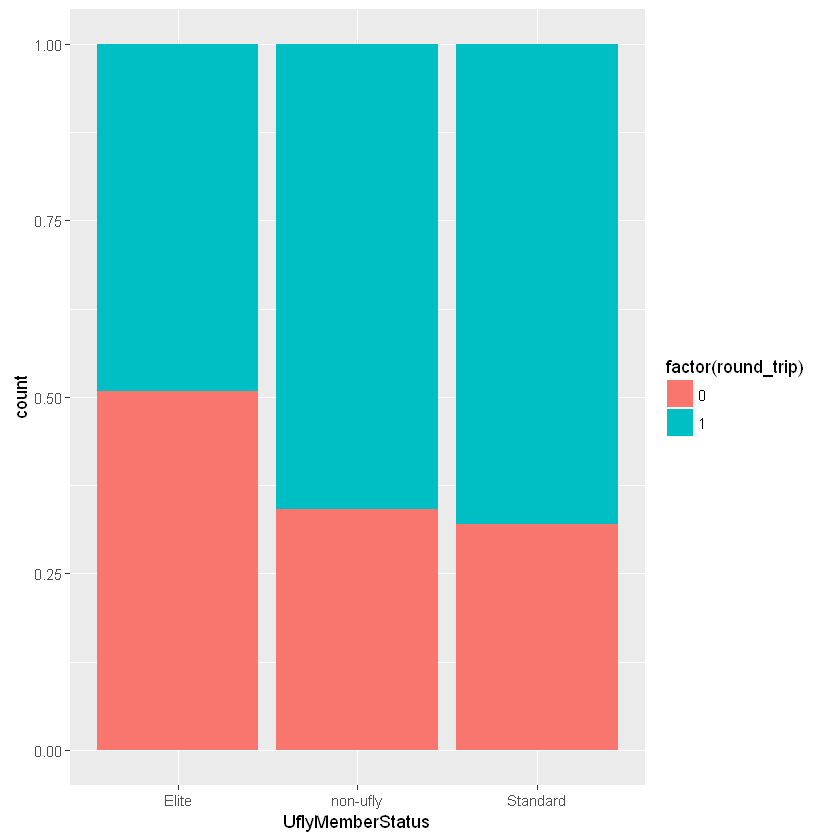

In [169]:
## roundtrip and uflymember ship
ggplot(k_means) + geom_bar(aes(UflyMemberStatus, fill = factor(round_trip)),position = "fill")

#### 1.How usable is the data you received from the client (Sun Country)? Given the state of the data,what steps would you take to make it usable and useful -- for the initial assigned project and for Sun Country longer term?

The data used from the Client is not in a usable state due to the presence of missingvalues, faulty entries and outliers in some of the variables. Apart from the quality issues with data the other issue due to which it cannot be used to derive customer level insights is structure of the database. In the given state the data is present at ticket level that is at PNRID level, in this structure there could be several entries of customer with diffrent PNRIDs. All the attributes that are currently at a ticket level needs to be transformed into informative attributes which will help us derive invaluable customer insights.

Steps to make the data usable for Project:
1. Data Cleaning - Removal of faulty values, replacement of missing values with identifiers and treatment of outliers
2. Data Fransformation - Create new variables at a customer level using attributes at PNR level.

Steps to make the data usable for longer term:
1. Reduction of data entry errors by employing regular data checks
2. Efficient storage of customer data in separate data bases to ensure data integrity.Eg: separate database for customers 

#### 2. Based on what you see in the data, how many different ways can you view the information to paint a picture of different customer segments? Which ways offer Sun Country the most insights? How could the insights be used?

Different ways to paint a picture of different customer segments:
1. Creating customer segments based on numeric data: The customers can be clustered into different groups by using the numerical attrinbutes such as average amount, groupsize and days prebooked as first step and then behaviour of other attributes in these groups can be observed. The ideal number of clusters are found by evluating the clusters generated by k-means and hierarchial clustering algorithm.
2. Using all the numerical and categorical attributes: using the hierarchial and k-mediods algorithms all the caustomer attributes can be used to categorize a group of customers. Even though all the attributes are used few dominant attributes will help classifying the customer group and help in deriving key customer insights.

Out of both the methods, customer groups created using numerical attributes offered better insights.
1. The groups formed by this method were comprised of customers who are similar each other in the group and distinct to customers in the other group. This was evident in comparison of silhoutte coefficent of all the methods and visulaizaiton of the clusters formed.

Number of optimal clusters chosen were 5

#### 3.  How would you visualize and present the insights you found for the client? What will you do in order to show Warnken and Vaughan how the insights you derived connect to their business objectives?

Following are the key in sights derived from the analysis and visualition of attributes of customers in 5 clusters. The customer attributes are plotted against number of clusters individually and combined with other attributes. Some of the insights are also drawn from the visulizations.

Cluster Names - are based on the cluster centers (clusters 1-5)

1- Advance booking Group Travellers 2- Low spending single Travellers 3- Medium spending single travellers 4- High Spending medium advance booking travellers 5- Advance booking Couple travellers

Insights drawn from the cluster analysis

1.	Cluster 1 is mostly distinguished by group_size. For avg amount and pre booking days, cluster 1 is all over the place.
2.	Out of all the people who use SY vacation, Advance booking couple travellers use it the most and single travellers use it the least
3.	Around 50% of the single travellers use website booking
4.	Out of all the people aged 0-17, advance booking group travellers are around 50%
5.	More than 75% of the people aged 18-24 are single travellers
6.	Advance booking couple travellers has the lowest presence in people aged 18-24
7.	Advance booking group travllers has highest presence in people aged 0-17 & 35-54
8.	Low spending single travellers has the least presence in 0-17
9.	Less than 10% of elite travellers are Advance booking group travellers and Advance booking couple travellers
10.	Most of the elite group is medium spending single travellers
11.	High spending medium adv booking travellers has the least presence in non-ufly
12.	High spending medium advance booking travellers don't book for round trips
13.	Low spending single travellers book round trips mostly

Several of the above insights help in assisting the client to answer their key questions

1. Performance of online booking channel ?
2. Improving Ufly membership ?

Taking decisions based on the data driven insights will involve less risk and help in formualting a strategy taking into account all the opportunities and risks.


#### 4.Discuss: how much power lies in simply understanding and exploring your data? Consider the downside of focusing too much on fancy models.

The following are the insights derived from the raw data analysis.
1.  Outside booking has its highest presence in age group 18-34
2.	Website booking has its highest presence in 0-17 and 5+
3.	Age group 0-17 doesn't have elite membership.
4.  Most of the 18-24 age group doesn't have ufly member ship.

From developing a good understanding of the raw data and exploring it to draw insights could be very helpful in several situations. 

For example, the above metioned insights are derived from the analysis of raw data only but they provide key information which could be very helpful to answer the clients' key questions.

The advantage of using these insights is that these can be generated much quicker since these don't involve  model building or employing algorithms which increases the amount of time taken to draw insights considering the huge volume of data.

So focussing too much on fancy models may cause delay in relaizing or collecting obvious or easy to draw insights which could be very valuable to the business, using raw data draw insights which could help in taking actions faster proves to invaluable.

